<a href="https://colab.research.google.com/github/sofiapizi/garbage_classification/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification

5105752 - Erica Pirondi

5108568 - Maria Sofia Pizi


This dataset has **15,515** images from **12** different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash. 

The **goal** of this project is to properly classify each image to its belonging class. 

Garbage Recycling is a key aspect of preserving our environment. To make the recycling process possible/easier, the garbage must be sorted to groups that have similar recycling process. 

URL: [https://www.kaggle.com/datasets/mostafaabla/garbage-classification](https://)

# Import libraries and install d2l package

In [ ]:
pip install d2l==1.0.0a1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 121 kB 37.5 MB/s 
     |████████████████████████████████| 1.6 MB 35.2 MB/s 
     |████████████████████████████████| 83 kB 2.8 MB/s 


In [ ]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
!pip install scikit-plot
import scikitplot as skplt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# drive connection
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/.shortcut-targets-by-id/1Ggdz5k0e1tIUnXnYJRZeVdM78K0lCPtX/Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Ggdz5k0e1tIUnXnYJRZeVdM78K0lCPtX/Project


#Data Preparation

### Import data and create the dataframe


In [ ]:
# label classes
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
print(categories)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
# define the base path
base_path = "/content/drive/MyDrive/Project/garbage_classification/"

In [ ]:
# Create the dataframe
filenames_list = []
categories_list = []

for category in categories:
  # take all file names for each category
    filenames = os.listdir(base_path + category)
    
    # add file and category names to lists
    filenames_list += filenames
    categories_list += [category] * len(filenames)

# create the dataframe
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# shuffle dataframe rows
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# show first 5 rows of out dataframe
df

,filename,category
0,battery447.jpg,battery
1,battery885.jpg,battery
2,trash633.jpg,trash
3,biological476.jpg,biological
4,clothes5006.jpg,clothes
...,...,...
15510,biological927.jpg,biological
15511,clothes2271.jpg,clothes
15512,shoes1686.jpg,shoes
15513,clothes1825.jpg,clothes


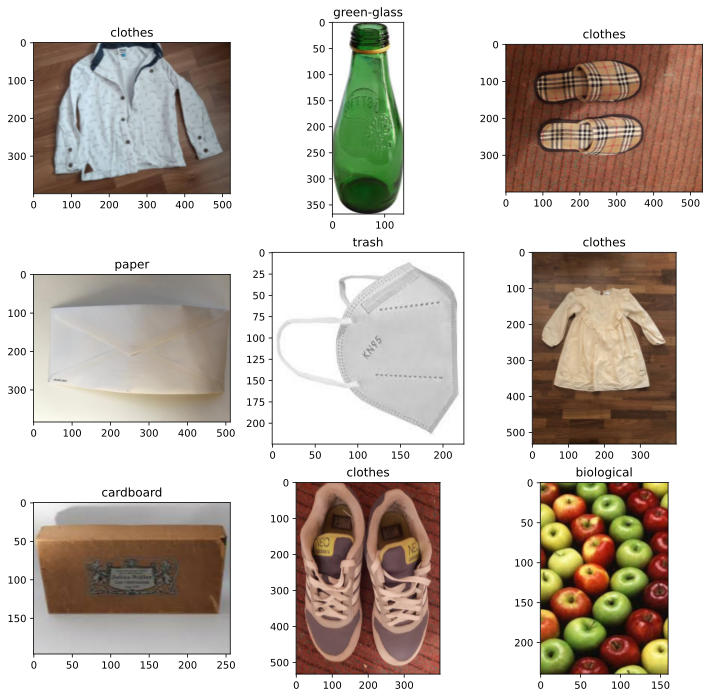

In [ ]:
# plot some images of the dataframe

plt.figure(figsize=(12,12))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['category'] + '/' + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

In [ ]:
# check distribution of dataframe

total_counts = 0

for category in os.listdir(base_path): # iterate on labels
    count_class = 0
    for photo in os.listdir(base_path + category): # iterate on filename
        count_class += 1
        total_counts += 1
    print(str(category) + " has " + str(count_class) + " images")

cardboard has 891 images
battery has 945 images
green-glass has 629 images
plastic has 865 images
metal has 769 images
shoes has 1977 images
biological has 985 images
brown-glass has 607 images
clothes has 5325 images
paper has 1050 images
white-glass has 775 images
trash has 697 images


### Balance the dataset through downsampling

We see that our dataset is quite **unbalanced**, hence we need to adjust it through downsampling. We reduce the size of major categories randomly selecting the images. 

In [ ]:
# group images according to categories
grouped = df.groupby(df['category'])

In [ ]:
# create subset for each category with 600 random selected photos

# obtain items belonging plastic group
plastic = grouped.get_group('plastic')
# sample from the group created 600 items
plastic = plastic.sample(n=600)

paper = grouped.get_group('paper')
paper = paper.sample(n=600)

battery = grouped.get_group('battery')
battery = battery.sample(n=600)

clothes = grouped.get_group('clothes')
clothes = clothes.sample(n=600)

biological = grouped.get_group('biological')
biological = biological.sample(n=600)

trash = grouped.get_group('trash')
trash = trash.sample(n=600)

brown_glass = grouped.get_group('brown-glass')
brown_glass = brown_glass.sample(n=600)

white_glass = grouped.get_group('white-glass')
white_glass = white_glass.sample(n=600)

green_glass = grouped.get_group('green-glass')
green_glass = green_glass.sample(n=600)

metal = grouped.get_group('metal')
metal = metal.sample(n=600)

shoes = grouped.get_group('shoes')
shoes = shoes.sample(n=600)

cardboard = grouped.get_group('cardboard')
cardboard = cardboard.sample(n=600)

In [ ]:
# create a list with the created subsets
subset = [battery, plastic, biological, paper, clothes, shoes, cardboard, green_glass, white_glass, brown_glass, trash, metal]

In [ ]:
# use concat to create a dataframe from the list
subset= pd.concat(subset)

In [ ]:
# check second dataframe
subset.shape

(7200, 2)

After selecting images to keep, we create a final subset folder in which we have only the 7200 images per class and all the class balanced:

In [ ]:
# create a list with filenames extracting them from the subset created before
file_name = subset['filename'].tolist()
# check list length
len(file_name)

7200

### Train and test split 

In [ ]:
# split the subset into train, validation and test

# select index for train and test
train_idx = random.sample(range(len(file_name)), int(len(file_name)*0.8))

test_idx = list(range(0,len(file_name)))
for item in train_idx:
  test_idx.remove(item)
test_idx = random.sample(test_idx, int(0.5*len(test_idx)))

# select index for validation
valid_idx = list(range(0,len(file_name)))
for item in test_idx:
  valid_idx.remove(item)
for item in train_idx:
  valid_idx.remove(item)

In [ ]:
# check subsets length
print('Check subsets length:')
print(' train:', len(train_idx),'\n','validaion:', len(valid_idx), '\n','test:', len(test_idx))
print('Sum of lengths:', len(train_idx)+len(valid_idx)+len(test_idx))

Check subsets length:
 train: 5760 
 validaion: 720 
 test: 720
Sum of lengths: 7200


In [ ]:
# extract items' name according to generated indexes
train_filename = []
test_filename = []
valid_filename = []

# train file name
for i in train_idx:
  train_filename.append(file_name[i])

# test file name
for j in test_idx:
  test_filename.append(file_name[j])

# validation file name
for k in valid_idx:
  valid_filename.append(file_name[k])

In [ ]:
# create a new reduced dataset with subclasses and train-validation-test division

import shutil

# define the new path
train_new_path = "/content/drive/MyDrive/Project/Subset2/Train"
valid_new_path = "/content/drive/MyDrive/Project/Subset2/Validation"
test_new_path = "/content/drive/MyDrive/Project/Subset2/Test"

for category in os.listdir(base_path): # iterate on labels
  for filename in os.listdir(base_path + category): # iterate on items' name

    # original item path
    image_path = base_path + '/' + category + '/' + filename
  
    # if item's name is in the train_file_name list created before, then copy it in the new train folder
    if filename in train_filename:
        # new sub folder path
        new_train_path_class = train_new_path + '/' + category
        # copy the item in the correct subfolder
        shutil.copy(image_path, new_train_path_class)
      
    # same reasoning for validation
    elif filename in valid_filename:
        # new sub folder path
        new_validation_path_class = valid_new_path + '/' + category
        # copy the item in the correct subfolder
        shutil.copy(image_path, new_validation_path_class)

    # same reasoning for test
    elif filename in test_filename:
        # new sub folder path
        new_test_path_class = test_new_path + '/' + category
        # copy the item in the correct subfolder
        shutil.copy(image_path, new_test_path_class)

In [ ]:
# create train dataframe to check correctness and class distribution

train_filenames_list = []
train_categories_list = []

for category in categories:
    train_filenames = os.listdir(train_new_path + '/' + category)
    
    train_filenames_list += train_filenames
    train_categories_list += [category] * len(train_filenames)

train_data = pd.DataFrame({
    'filename': train_filenames_list,
    'category': train_categories_list
})

train_data = train_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# check number of items
train_data.shape

(5760, 2)

In [ ]:
# check class distribution
train_data.groupby(['category']).count()

,filename
category,
battery,473
biological,481
brown-glass,483
cardboard,473
clothes,486
green-glass,464
metal,478
paper,475
plastic,489


In [ ]:
# create validation dataframe to check correctness and class distribution

valid_filenames_list = []
valid_categories_list = []

for category in categories:
    valid_filenames = os.listdir(valid_new_path + '/' + category)
    
    valid_filenames_list += valid_filenames
    valid_categories_list += [category] * len(valid_filenames)

valid_data = pd.DataFrame({
    'filename': valid_filenames_list,
    'category': valid_categories_list
})

valid_data = valid_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# check items' number
valid_data.shape

(720, 2)

In [ ]:
# check class distribution
valid_data.groupby(['category']).count()

,filename
category,
battery,68
biological,60
brown-glass,63
cardboard,72
clothes,52
green-glass,64
metal,62
paper,57
plastic,60


In [ ]:
# create test dataframe to check correctness and class distribution

test_filenames_list = []
test_categories_list = []

for category in categories:
    test_filenames = os.listdir(test_new_path + '/' + category)
    
    test_filenames_list += test_filenames
    test_categories_list += [category] * len(test_filenames)

test_data = pd.DataFrame({
    'filename': test_filenames_list,
    'category': test_categories_list
})

test_data = test_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# check items' number
test_data.shape

(720, 2)

In [ ]:
# check class distribution
test_data.groupby(['category']).count()

,filename
category,
battery,59
biological,59
brown-glass,54
cardboard,55
clothes,62
green-glass,72
metal,60
paper,68
plastic,51


# Import data as ImageFolder and prepare DataLoader

In [ ]:
# set the roots
train_path = "/content/drive/MyDrive/Project/Subset2/Train"
valid_path = "/content/drive/MyDrive/Project/Subset2/Validation"
test_path = "/content/drive/MyDrive/Project/Subset2/Test"

> *To increment the number of data and obtain better performances we implement data aumgmentation 3 times on train dataset. 
Then, the original train dataset is concatenated with the augmented data having the final dataset.*

In [ ]:
# first augmentation: horizontal roation

aug1 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(p=1),
  transforms.Resize((96,96))])

In [ ]:
# second augmentation: random crop and random rotation of 45 degrees.

aug2 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop((96,96), scale=(0.1, 0.7), ratio=(0.5, 2)), 
  transforms.RandomRotation(degrees = 45), 
  transforms.Resize((96,96))])

In [ ]:
# third augmentation: modify images' brightness

aug3 = transforms.Compose([
  transforms.ToTensor(),
  transforms.ColorJitter(brightness=0.25, contrast=0, saturation=0, hue=0), 
  transforms.Resize((96,96))])

In [ ]:
# fourth augmentation: perform random sharpness increments

aug4 = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
  transforms.Resize((96,96))])

In [ ]:
# transform to tensor train folder without modifications

trans_without_aug = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((96,96))])

In [ ]:
# implement transformations for validation folder

valid_trans = transforms.Compose([ 
  transforms.ToTensor(),
  transforms.Resize((96,96))])

In [ ]:
# implement transformations for test folder

test_trans = transforms.Compose([ 
  transforms.ToTensor(),
  transforms.Resize((96,96))])

In [ ]:
# create the final joined dataset
l= [] #empty list

# append to the list folders with respective transformations
l.append(datasets.ImageFolder(root = train_path, transform = aug1))
l.append(datasets.ImageFolder(root = train_path, transform = aug2))
l.append(datasets.ImageFolder(root = train_path, transform = aug3))
l.append(datasets.ImageFolder(root = train_path, transform = aug4))
l.append(datasets.ImageFolder(root = train_path, transform = trans_without_aug))

# concatenate the dataset
train_iter = torch.utils.data.ConcatDataset(l)

# import validation dataset
valid_iter = datasets.ImageFolder(root = valid_path, transform = valid_trans)

# import test dataset
test_iter_IF = datasets.ImageFolder(root = test_path, transform = test_trans)

In [ ]:
# build data loaders
batch_size=64
train_iter = data.DataLoader(train_iter, batch_size, shuffle=True, num_workers= 2)
valid_iter = data.DataLoader(valid_iter, batch_size, shuffle=True, num_workers= 2)
test_iter_DL = data.DataLoader(test_iter_IF, batch_size, shuffle=True, num_workers= 2)

# GoogleNet

*GoogLeNet uses networks with parallel concatenations. It uses a stack of a total of 9 inception blocks which consist in 4 parallel paths and global average pooling to generate its estimates. Lastly, maximum pooling between inception blocks reduces the dimensionality.*

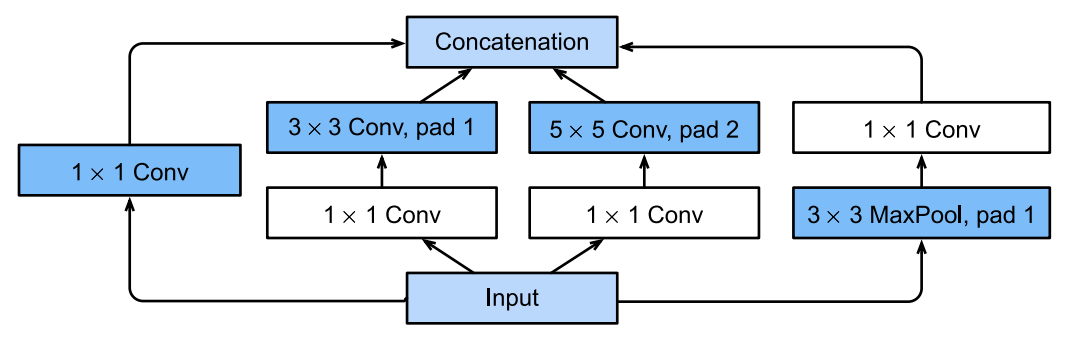

### Implement GoogleNet architecture

In [ ]:
# build inception blocks
from torch.nn import functional as F

class Inception(nn.Module):
    def __init__(self, input_ch, output_ch1, output_ch2, output_ch3, output_ch4, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        # Build 4 parallel paths
        # Path 1: it uses a 1x1 convolutional layer
        self.p1_1 = nn.Conv2d(input_ch, output_ch1, kernel_size=1) 
        # Path 2: is a 1x1 convolutional layer and it reduces the number of channels,
        # followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(input_ch, output_ch2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(output_ch2[0], output_ch2[1], kernel_size=3, padding=1)
        # Path 3: is a 1 x 1 convolutional layer and it reduces the number of channels,
        # followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(input_ch, output_ch3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(output_ch3[0], output_ch3[1], kernel_size=5, padding=2)
        # Path 4: is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(input_ch, output_ch4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) 
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

Build the architecture:

> *We implement the traditional GoogleNet architecture with some modifications. We decided to apply batch normalization layers to normalize data and to accelerate the covergence of the deep neaural network, implementing BatchNorm2d after each convolutional layer, before entering the nonlinear activation function.*
>
>*We also add the dropout layer before the fully connected linear layer at the end, with probability equal to 0.5, to avoid overfitting of the data.*
>
>
>*Lastly, we decided to add the LogSoftmax layer, which takes the logarithm of softmax probabilities. Having this layer allows us to reach numerical stability and lower the loss function since faster convergence to the optimum.*

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Dropout(p=0.5), nn.Linear(1024, 12), nn.LogSoftmax(dim = 1))

In [ ]:
# check the architecture

X = torch.rand(size=(1, 3, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Dropout output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 12])
LogSoftmax output shape:	 torch.Size([1, 12])


loss 0.430, train acc 0.862, test acc 0.787
1136.3 examples/sec on cuda:0


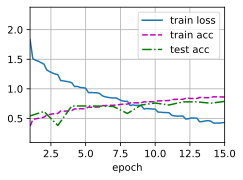

In [ ]:
# perform training
lr, num_epochs = 0.07, 15
d2l.train_ch6(net, train_iter, valid_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# save the model
torch.save(net, 'g_model.pt')

In [ ]:
# load the model
g_model = torch.load('g_model.pt')

### Prediction

In [ ]:
# make prediction
for x, y in test_iter_DL:
  break
x , y = x.cuda(), y.cuda()
pred = torch.exp(g_model(x)).argmax(axis=1)

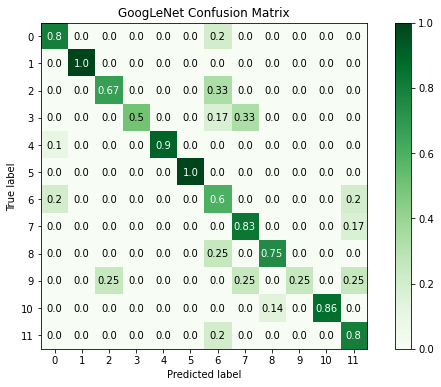

In [ ]:
# compute the confusion matrix
skplt.metrics.plot_confusion_matrix(y.cpu(), pred.cpu(), normalize=True, cmap = 'Greens', figsize=(10,6), title = 'GoogLeNet Confusion Matrix')

In [ ]:
# compare predicted results with real values
print(pred)
print(y)

tensor([ 6,  6, 11,  4, 10,  8,  8, 11,  8,  0,  3,  7,  3,  3,  5,  4, 11,  4,
         5,  5,  0,  4, 10,  3, 10,  9,  8,  9, 10,  1,  0,  2,  8,  0,  6, 11,
         5, 10,  1, 10,  9,  4,  8,  2,  1,  2,  0,  1,  4,  4,  7,  6,  8,  8,
         9,  0,  0, 11,  8,  8,  5, 11,  0,  5], device='cuda:0')
tensor([ 7,  6, 11,  4, 10,  0, 11, 11, 11,  0,  3,  7,  3,  3,  5,  4, 11,  4,
         5,  5,  6,  4, 10,  3, 10,  9,  7,  9, 10,  1,  0,  2,  8,  6,  6, 11,
         5, 11,  0, 10,  9,  4,  0,  2,  1,  5,  0,  1,  4,  4,  7,  6,  8,  8,
         3,  6,  0,  7,  8,  9,  5,  7,  0,  5], device='cuda:0')


In [ ]:
# define a function to plot test images with real and predicted labels
def show(net, test_iter, n=6):

  # create two empy list for real and predicted labels
  titles = []
  pred_titles = []

  # define index j to access values in lists above
  j = 0
  
  # access iteratively data laoder elements
  x_iter, y_iter = next(iter(test_iter_DL))

  # move x_iter to cuda to make predictions
  x_iter = x_iter.cuda()
  # make prediction with g_model and find most probable class
  pred = torch.exp(net(x_iter)).argmax(axis=1)

  # define a random index to plot images randomly
  random_idx = random.sample(range(64), n)

  # move back x_iter to cpu to allow comparisons
  x_iter = x_iter.cpu()


  for i in random_idx:
    # access single image and permute it to allow plotting
    img = x_iter[i].permute(1,2,0)

    # associate labels to indexes using ImageFolder classes
    for idx, label in enumerate(test_iter_IF.classes):

      # check if the index stored in the y variable corresponds to the index of the ImageFolder class
      if y_iter[i] == idx:
        # if yes, appen the label which correspond to that index to the list
        titles.append(label)

      # same reasoning for the predicted classes
      if pred[i].cpu() == idx:
        pred_titles.append(label)
   
    # plot the image
    plt.imshow(img)
    # add title accessing j-th element in the list
    plt.title(f'True label: {titles[j]} \n Predict label: {pred_titles[j]}')
    # show image
    plt.show()
    
    # increment the counter to access following elements of the lists
    j+=1

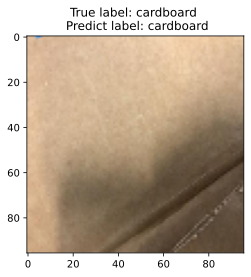

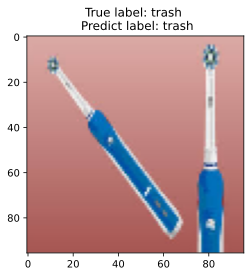

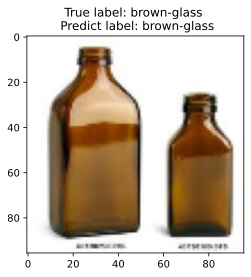

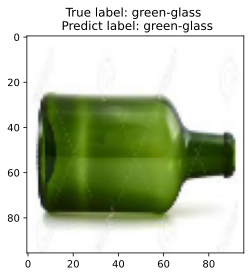

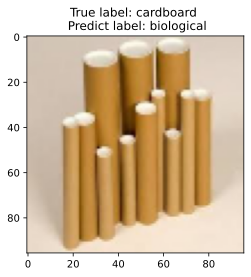

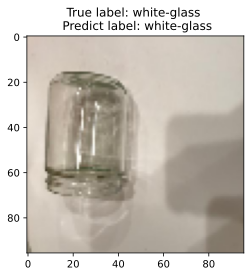

In [ ]:
# plot images
show(g_model, test_iter_DL)

# Convolutional Recurrent Neural Network

*Convolutional Recurrent Neural Network is a hybrid of convolutional and recurrent neural network. In our case, we decided to implement this model since we could benefit from both networks' capabilities. The convolutional layers are able to extract middle-level, abstract and locally invariant features from the input sequence. The pooling layers help reduce computation and control overfitting. Second, the recurrent layers extract contextual information from the feature sequence generated by the previous convolutional layers.*

Our CRNN architecture is composed by:


1. One convolutional block:

      *   Fist CNN: 3x3 convolutional layer, followed by a dropout layer (with probability 0.1), a batch normalization layer and a 3x3 max pooling layer 
      *   Second CNN: 3x3 convolutional layer, followed by a batch normalization layer
      * Third CNN: 3x3 convolutional layer, followed by a batch normalization layer and a 3x3 max pooling layer
      * Fourth CNN: 3x3 convolutional layer, followed by a batch normalization layer

2. One recurrent layer, with 64 hidden layers 
3. One dense block:
      * a dropout layer with probability 0.5
      * a linear layer with output size 12 (number of classes)
4. A log softmax layer




In [ ]:
class ConvRNN(nn.Module):
    def __init__(self, input_ch = 3, output_ch1 = 8, output_ch2 = 16, output_ch3 = 32, output_ch4 = 64, kernel_size = 3, hidden = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch, output_ch1, kernel_size = kernel_size, stride = 3, padding = 1)
        self.drop1 = nn.Dropout(p=0.1)
        self.batch1 = nn.BatchNorm2d(output_ch1)
        self.max1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(output_ch1, output_ch2, kernel_size = kernel_size)
        self.batch2 = nn.BatchNorm2d(output_ch2)
        self.conv3 = nn.Conv2d(output_ch2, output_ch3, kernel_size = kernel_size)
        self.batch3 = nn.BatchNorm2d(output_ch3)
        self.max2 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(output_ch3, output_ch4, kernel_size = kernel_size, stride = 3, padding = 1)
        self.batch4 = nn.BatchNorm2d(output_ch4)

        self.rnn1 = nn.RNN(10, hidden, batch_first = True, nonlinearity = 'relu', num_layers = 1)

        self.flat = nn.Flatten()
        self.drop_lin = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(40960, 12)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.drop1(x)
        x = self.batch1(x)
        x = self.max1(x)
        x = torch.relu(self.conv2(x))
        x = self.batch2(x)
        x = torch.relu(self.conv3(x))
        x = self.batch3(x)
        x = self.max2(x)
        x = torch.relu(self.conv4(x))
        x = self.batch4(x)

        x = x.reshape(x.shape[0], x.shape[2]*x.shape[1], x.shape[3])
        
        x, _ = self.rnn1(x)

        x = self.flat(x)
        x = self.drop_lin(x)
        x = self.linear1(x)

        x= self.soft(x)

        return x

In [ ]:
# Create network
net_crnn = ConvRNN()

loss 0.422, train acc 0.874, test acc 0.749
3685.8 examples/sec on cuda:0


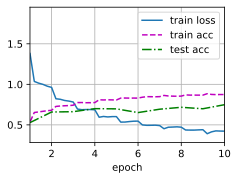

In [ ]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net_crnn, train_iter, valid_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# save crnn mdoel
torch.save(net_crnn, 'crnn_model.pt')

In [ ]:
# load crnn model
crnn_model = torch.load('crnn_model.pt')

### Prediction

In [ ]:
for x, y in test_iter_DL:
  break
x , y = x.cuda(), y.cuda()
pred_crnn = torch.exp(crnn_model(x)).argmax(axis=1)

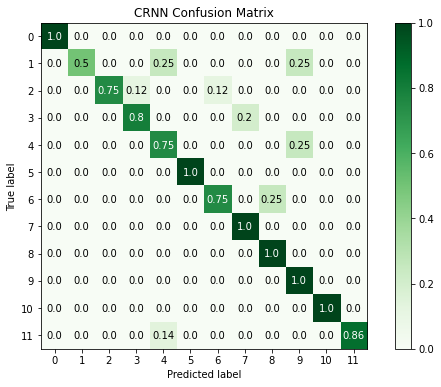

In [ ]:
# confusion matrix
skplt.metrics.plot_confusion_matrix(y.cpu(), pred_crnn.cpu(), normalize=True, cmap = 'Greens', figsize=(10,6), title = 'CRNN Confusion Matrix')

In [ ]:
print(pred_crnn)
print(y)

tensor([ 9, 11,  6,  5,  7,  4,  7, 11,  9,  6, 11,  5,  3,  6,  8,  1,  6, 11,
         0,  8,  6,  7,  6,  5,  6,  2,  8,  3,  4, 10,  3,  2,  3,  7, 11, 10,
         3,  8,  4,  7,  6,  4,  8,  7,  7,  4,  5, 10,  4,  2,  5,  9, 10,  4,
        11,  6,  8,  5,  9,  1, 10,  6,  0,  0], device='cuda:0')
tensor([ 9,  6,  6,  5,  3,  9,  7, 11,  4,  6, 10,  0,  6,  6, 10,  1,  7, 11,
         0,  8,  9, 11,  6,  5,  6,  2,  8,  3,  4, 10,  9,  2,  3,  7, 11, 10,
         2,  8,  4,  6,  7,  4,  8,  7,  7,  4,  5, 10,  1,  2,  5, 11, 10,  4,
        11,  6,  1,  5,  9,  0, 10,  9,  0,  0], device='cuda:0')


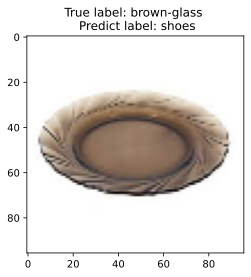

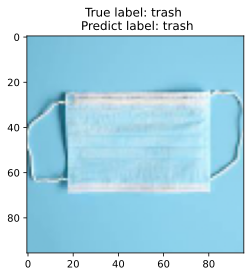

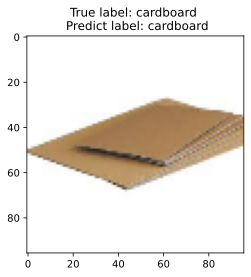

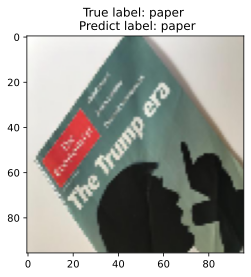

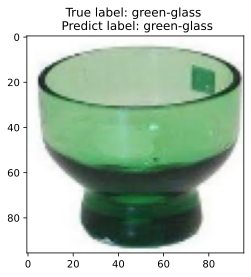

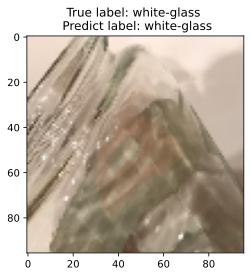

In [ ]:
show(crnn_model, test_iter_DL)

# Conclusions

The aim of the project was to classify images into 12 garbage classes. 
We implemented 2 models, on a balanced dataset and devided it into train, validation and test set. 

For the first model, we implemented **GoogLeNet** which took about 25 minutes to execute and trained on about 25000 images. The **test** **accuracy** for this model was **0.787**, having no particular overfitting problem and performing **1136.3 examples per second**. We reached this result in 15 epochs.

For the second model, we implemented customized **CRNN** which took about 17 minutes to execute and trained on the same dataset as the first model. The **test** **accuracy** for this model was **0.749**, but encountering a small problem of overfitting and performing **3685.8 examples per second**. We reached this result in 10 epochs, which suggests that this model converges faster with respect to the GoogLeNet model. 

Overall, there is not a model which significantly outperforms another. However, considering that the GoogLeNet architecture is a well consolidated model we can conclude that with a bit more research on convolutional recurrent neural network better performance can be achieved. 

